In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

from skimage.transform import resize

from dataloader_cocostyle import image_graph_collate_road_network_coco, min_max_normalize
from dataloader_cocostyle_road import CrowdAIRoad
from pretrain import dict2obj
from models.TopDiG import build_TopDiG

loading annotations into memory...
Done (t=1.81s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1288
--Gap Distance: 10 --Sigma: 0.8 --nms: False
torch.Size([4, 3, 320, 320])
0.9964882 0.0


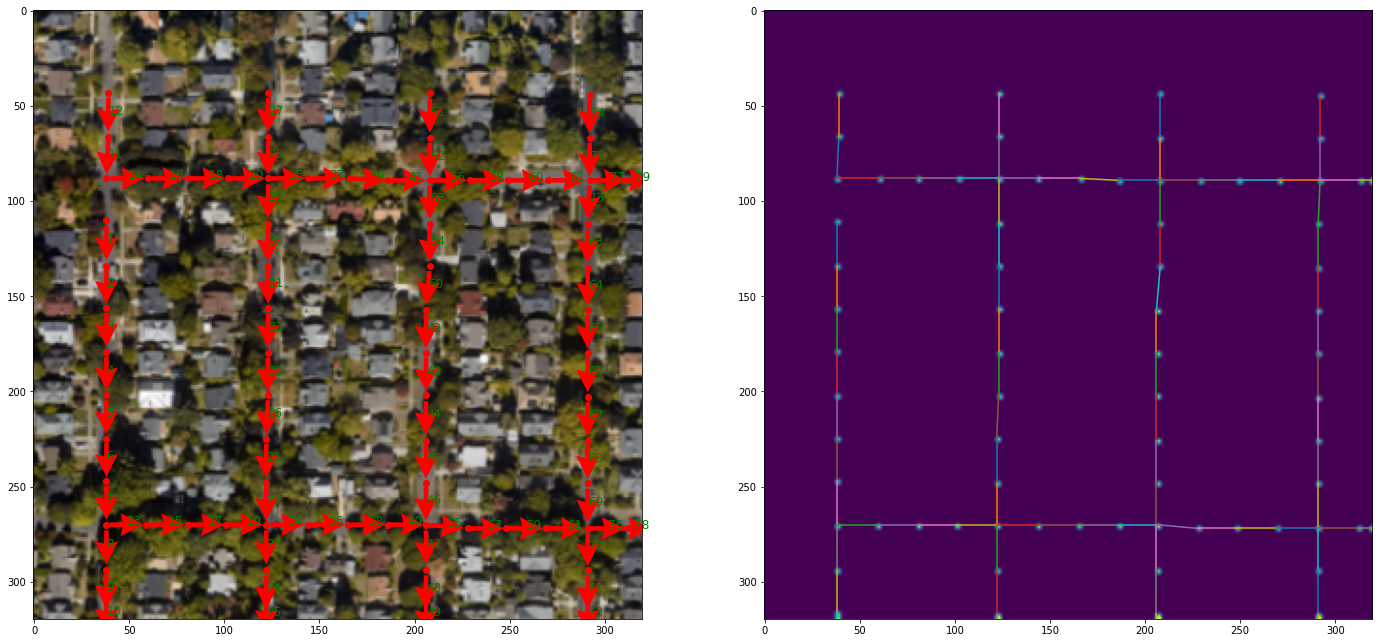

In [2]:
dataset = CrowdAIRoad(images_directory='/nas/k8s/dev/research/doyoungi/dataset/sat2graph/cocostyle_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/sat2graph/cocostyle_test/annotation.json',
                    gap_distance=10,
                    sigma=0.8,
                    nms=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

image = data[0][0].detach().cpu().numpy().transpose(1,2,0)
heatmap = data[1][0].detach().cpu().numpy()[0]
gt_nodes = data[2][0].detach().cpu().numpy() * image.shape[0]
gt_edges = data[3][0].detach().cpu().numpy()

gt_nodes = gt_nodes.astype('int64')

print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')

for idx, e in enumerate(gt_edges):
    if int(idx%160) == 0:
        continue
    else:
        connect = np.stack([gt_nodes[e[0]], gt_nodes[e[1]]], axis=0)

        mid_point = np.mean(connect, axis=0)
        direction = connect[1] - connect[0]
        direction = direction / np.linalg.norm(direction)
        ax[0].quiver(mid_point[1], mid_point[0], direction[1], direction[0], 
                    pivot='mid',
                    angles='xy', scale_units='xy', color='red', headwidth=5, headlength=5)
        
        ax[0].text(mid_point[1], mid_point[0], f'{idx}', color='green', fontsize=12)
        ax[1].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap)
plt.show()


In [3]:
config_file = "../configs/topdig/topdig_road.yaml"
# config_file2 = '../configs/road/topdig_10_1.0_nearest_diag.yaml'
config_file2 = '../configs/road/topdig_10_1.0_hungarian_diag.yaml'

ckpt_backbone_path = '../work_dirs/road/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_10/models/epochs_200.pth'
# ckpt_path = '../work_dirs/TopDiG_train/runs/road_baseline_TopDiG_train_epoch20_topdig_10_1.0_sinkhorn_diag_10/models/epochs_20.pth'
# ckpt_path = '../work_dirs/road/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_nearest_diag_10/models/epochs_20.pth'
ckpt_path = '../work_dirs/road/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_hungarian_diag_10/models/epochs_20.pth'


with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_backbone_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

checkpoint2 = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint2['model_state_dict'], strict=False) # 여기서 TopDiG 학습한 체크포인트 로드
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))
# model.eval()
device = torch.device("cuda")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

In [4]:
device = 'cuda'
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
with torch.no_grad():
    out = model(images)
scores1, scores2 = out['scores1'], out['scores2']
htm_TopDiG, nms_TopDiG = out['pred_heatmaps'], (out['pred_nodes']*320)
nms_TopDiG = nms_TopDiG.type(torch.int)
print(htm_TopDiG[1].unique())
print(nms_TopDiG[1][:10])

tensor([-8.6345, -8.6107, -8.6006,  ...,  5.5732,  5.5861,  6.1368],
       device='cuda:0')
tensor([[272,   0],
        [319,  53],
        [133,  56],
        [248, 140],
        [319, 139],
        [111, 141],
        [268, 140],
        [ 91,  57],
        [271,  54],
        [113,  56]], device='cuda:0', dtype=torch.int32)


In [5]:
from scipy.optimize import linear_sum_assignment # Scipy에 구현된 헝가리안 알고리즘 사용

def scores_to_permutations(scores): # 인퍼런스용 함수
    """
    Input a batched array of scores and returns the hungarian optimized 
    permutation matrices.
    """
    B, N, N = scores.shape

    scores = scores.detach().cpu().numpy()
    perm = np.zeros_like(scores)
    for b in range(B):
        # sinkhorn 알고리즘은 비공개된 트레인 파일에 있을 듯
        # 반복적인 노멀라이제이션(100번)을 위해 싱크홀 알고리즘 사용
        # 인퍼런스시에 헝가리안 알고리즘으로 linear sum assignment result 뽑는다
        r, c = linear_sum_assignment(-scores[b]) # 점수가 높을 수록 페어일 확률이 높으므로 -를 붙여서 최소 찾는 문제로 바꾼다.
        perm[b,r,c] = 1 # 헝가리안 알고리즘이 찾은 칸은 1로 아니면 0인 permutation matrix (B N N) 만든다
    return torch.tensor(perm) # 텐서로 바꿔주기

예측 노드 수: 256
선택된 예측 노드 수: 94
정답 노드 수: 86


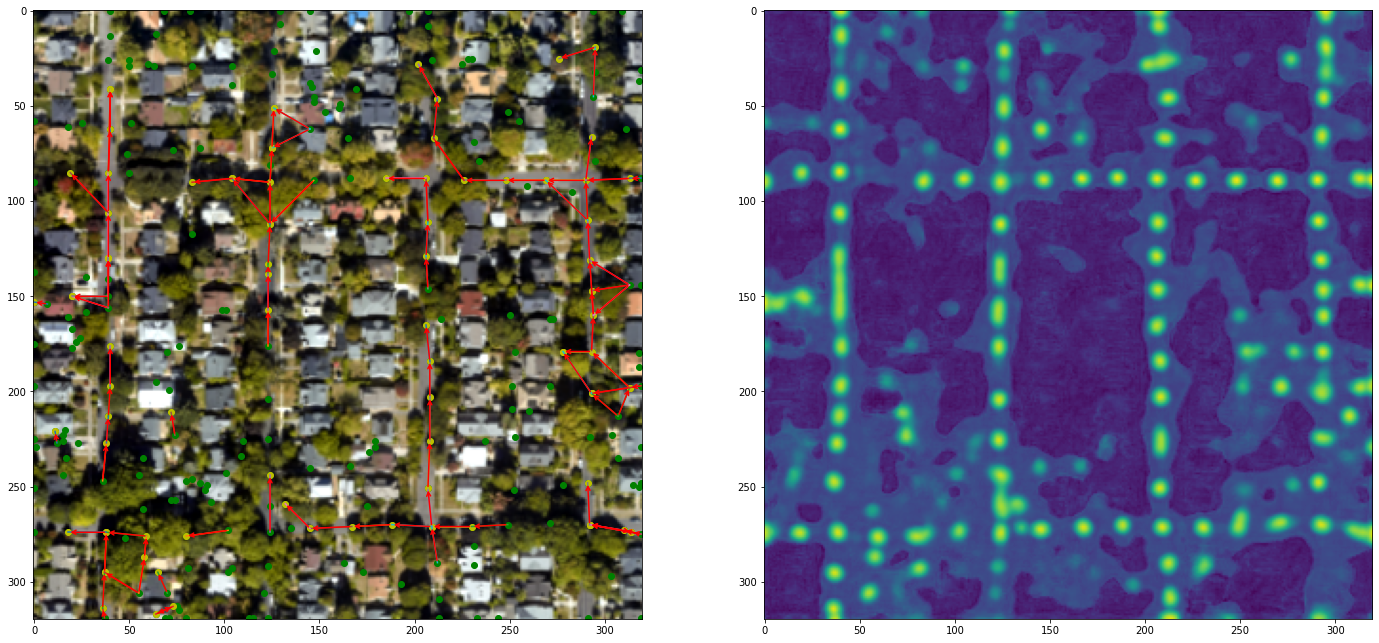

In [6]:
idx_of_batch = 0
scores = scores1.sigmoid() + scores2.transpose(1,2).sigmoid()

# permu = scores_to_permutations(scores)
permu = scores.detach().cpu() > 0.5
mat = permu[idx_of_batch].numpy()
edges = []
for i in range(len(mat)):
    for j in range(len(mat)):
        if mat[i][j] == 1:
            if i != j:
                # print(i, j)
                edges.append((i,j))
htm = htm_TopDiG[idx_of_batch,0].detach().cpu().numpy()
nodes = nms_TopDiG.detach().cpu().numpy()
image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)
nodes = nodes[idx_of_batch]

print("예측 노드 수:", len(nodes))
print("선택된 예측 노드 수:", len(edges))
print("정답 노드 수:", len(data[2][1].detach().cpu().numpy()))

# Visualize
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0.5))
ax[1].imshow(htm_TopDiG[idx_of_batch,0].detach().cpu().numpy())
ax[0].scatter(nodes[:,1], nodes[:,0], color='g')
for x, _ in edges:
    ax[0].scatter(nodes[x][1], nodes[x][0], color='y')
for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])
    ax[0].annotate("", xy=nodes[e[0]][::-1], xytext=nodes[e[1]][::-1], 
                arrowprops=dict(arrowstyle="->", lw=1.5, color='r'))

plt.show()

In [7]:
from models.DGS import Matcher

nearest_matcher = Matcher(config=config2, matcher='Nearest')
hungarian_matcher = Matcher(config=config2, matcher='Hungarian')
sinkhorn_matcher = Matcher(config=config2, matcher='Sinkhorn')

width = 320

outputs, targets = {}, {}
targets['nodes'] = torch.tensor(gt_nodes).unsqueeze(0).float() / width # [1, 78, 2]
targets['edges'] = torch.tensor(gt_edges).unsqueeze(0) # [1, 115, 2]
outputs['pred_nodes'] = torch.tensor(nodes).unsqueeze(0).float() / width # [1, 256, 2]
outputs['pred_heatmaps'] = torch.tensor(htm).unsqueeze(0).unsqueeze(0) # [1, 1, 320, 320]
nearest_adj_matrix, _, nearest_matched_pairs = nearest_matcher(outputs, targets)
hungarian_adj_matrix, _, hungarian_matched_pairs = hungarian_matcher(outputs, targets)
# _, _, sinkhorn_matched_pairs = sinkhorn_matcher(outputs, targets, config=config)

end_rule for road_dataset
end_rule for road_dataset


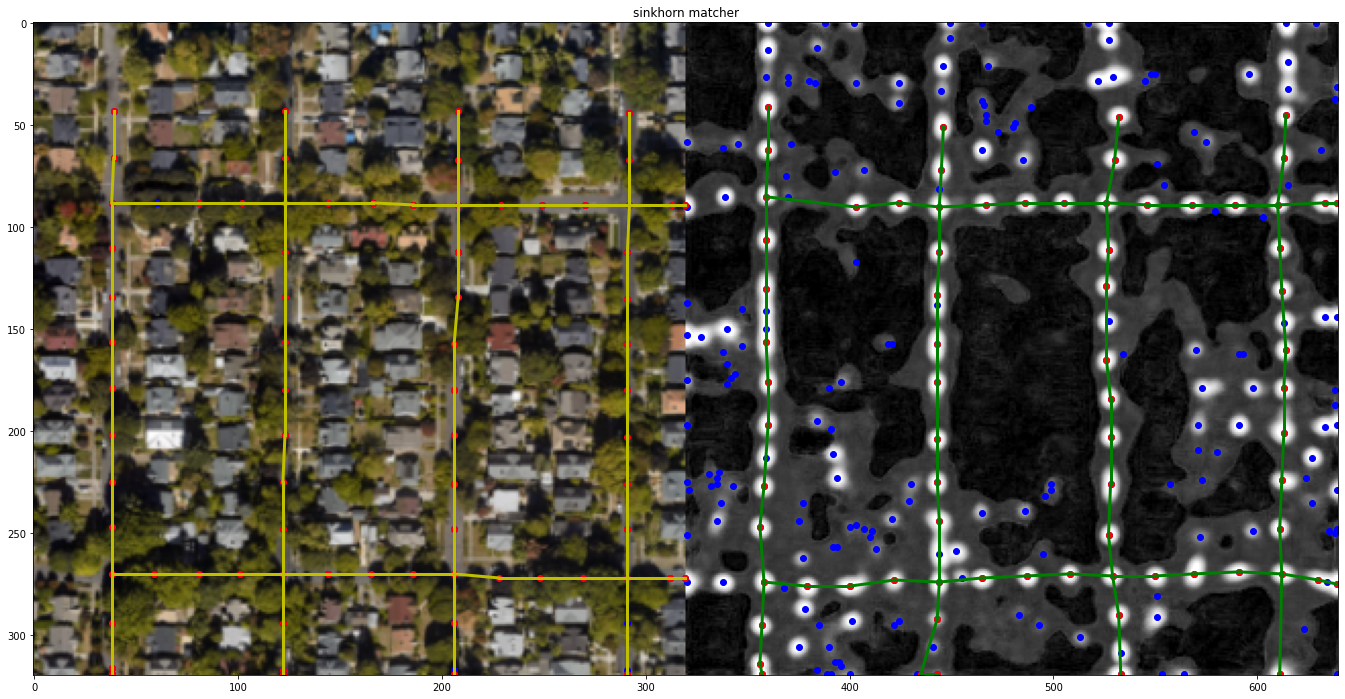

In [55]:
# htm = htm_TopDiG[idx_of_batch,0].detach().cpu().numpy()
# image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)
htms = np.stack([htm, htm, htm], axis=2)
draw_image = np.concatenate([min_max_normalize(image, 0), min_max_normalize(htms,2)], axis=1)
draw_gt_node = gt_nodes # .detach().cpu().numpy()
draw_pred_node = nodes + [0, 320]

match_indices = nearest_matched_pairs[0]

# Visualize
fig, ax = plt.subplots(1,1, figsize=(24, 12))
ax.imshow(draw_image)

ax.scatter(draw_gt_node[:,1], draw_gt_node[:,0], color='b')
ax.scatter(draw_pred_node[:,1], draw_pred_node[:,0], color='b')

ax.scatter(draw_gt_node[match_indices[1]][:,1], draw_gt_node[match_indices[1]][:,0], color='r')
ax.scatter(draw_pred_node[match_indices[0]][:,1], draw_pred_node[match_indices[0]][:,0], color='r')

match_indices = np.array(match_indices).transpose(1,0)
match_dict = {i[1]:i[0] for i in match_indices.tolist()}

for e in gt_edges:
    p1 = np.array(draw_gt_node[e[1]])
    p2 = np.array(draw_gt_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'y', linewidth=3)


# for i in match_indices:
#     p1 = np.array(draw_gt_node[i[1]])
#     p2 = np.array(draw_pred_node[i[0]])
#     p = np.stack([p1, p2], axis=0)
#     ax.plot(p[:,1], p[:,0], 'g')


loc = np.array(np.where(nearest_adj_matrix[0].detach().cpu().numpy() == 1)).transpose(1,0)
# loc = np.array(np.where((adj_matrix + adjs == 1.0) == 1)).transpose(1,0)
# loc = np.array(np.where(adjs == 0.5)).transpose(1,0)    
for e in loc:
    p1 = np.array(draw_pred_node[e[1]])
    p2 = np.array(draw_pred_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'g', linewidth=3)
    
plt.title("sinkhorn matcher")
plt.show()

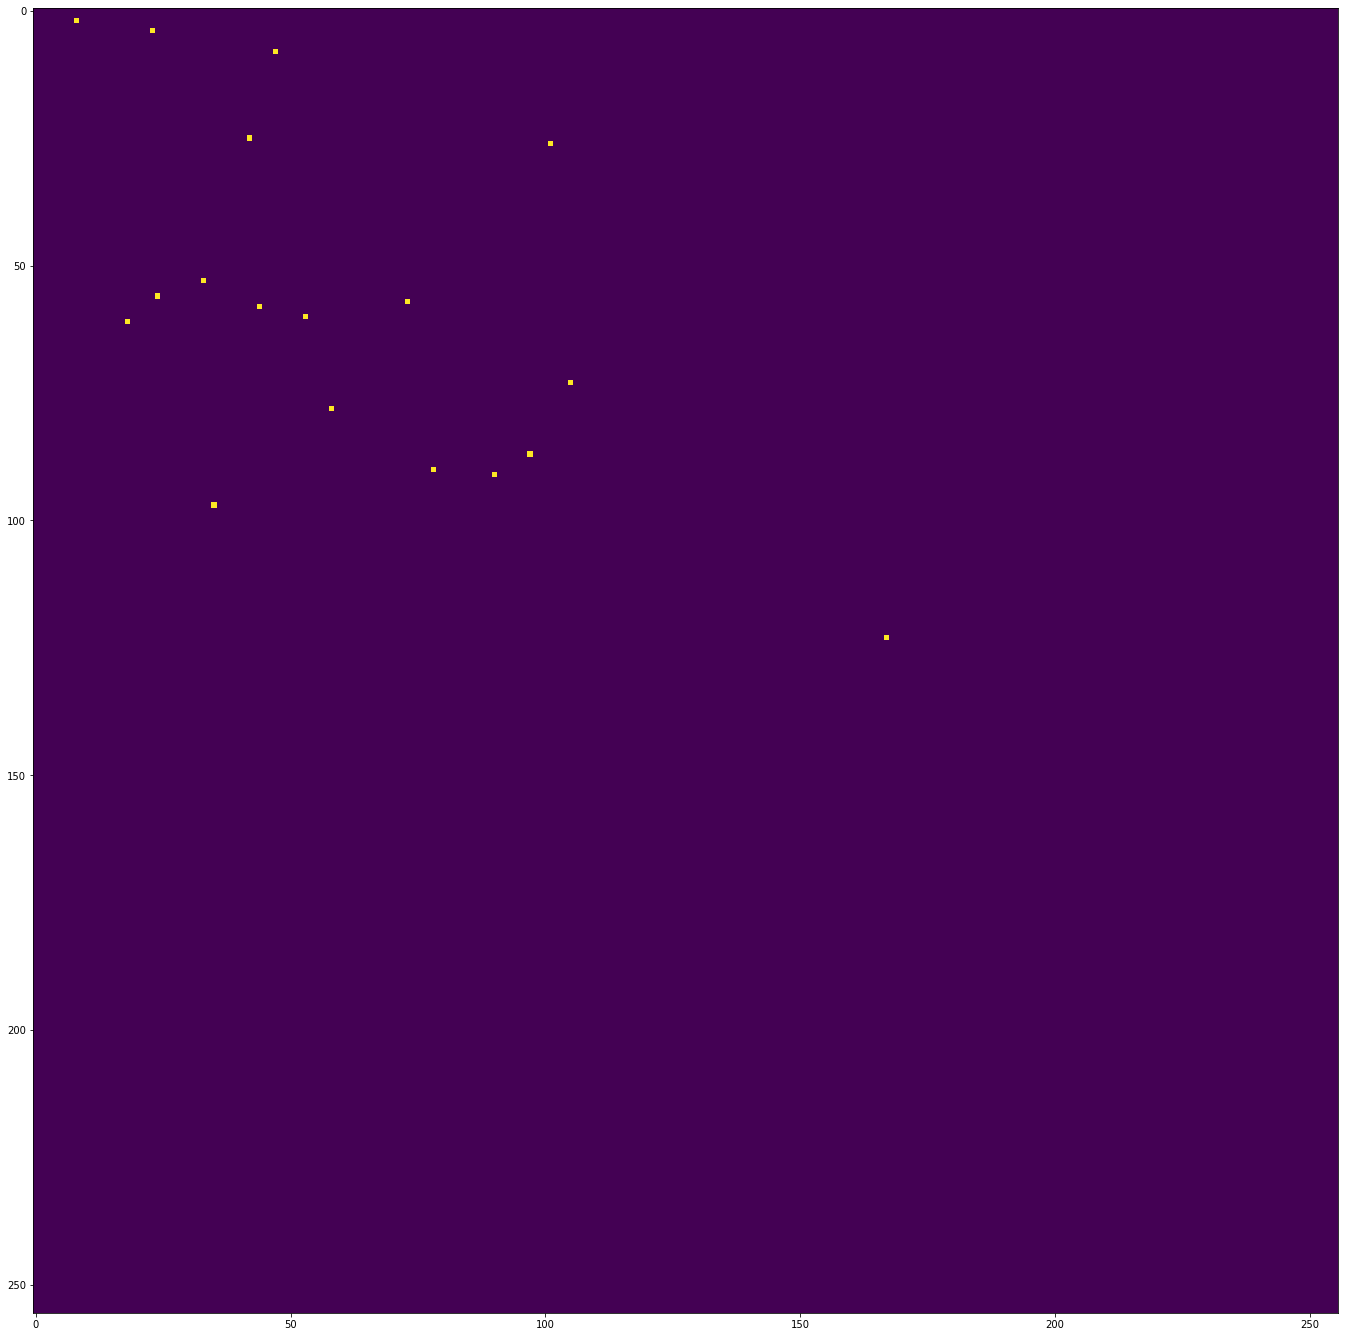

In [48]:
adj_matrix = nearest_adj_matrix[0].detach().cpu().numpy()
plt.figure(figsize=(24,24))
plt.imshow(adj_matrix + adjs == 1.0)